In [1]:
import numpy as np
import pandas as pd

# Introduction
This notebook will broadly follow the approach laid out in chapter 9 of "Deep Learning for Coders with fastai and PyTorch," titled "Tabular Modeling Deep Dive." Our initial goal is to get a deep learning model running and able to produce a valid submission as quickly as possible, after which we can do some more thoughtful EDA and iterate on the model.

In [2]:
from fastai.tabular.all import *
path = Path('../input/lish-moa')
path.ls()

(#6) [Path('../input/lish-moa/sample_submission.csv'),Path('../input/lish-moa/train_drug.csv'),Path('../input/lish-moa/train_targets_scored.csv'),Path('../input/lish-moa/train_targets_nonscored.csv'),Path('../input/lish-moa/train_features.csv'),Path('../input/lish-moa/test_features.csv')]

In [3]:
train_features = pd.read_csv(path/'train_features.csv')
test_features = pd.read_csv(path/'test_features.csv')
train_targets = pd.read_csv(path/'train_targets_scored.csv')
train_drugs = pd.read_csv(path/'train_drug.csv')
sub = pd.read_csv(path/'sample_submission.csv')

From the documentation:

>Features for the training set. Features `g-` signify gene expression data, and `c-` signify cell viability data. `cp_type` indicates samples treated with a compound (`cp_vehicle`) or with a control perturbation (`ctrl_vehicle`); control perturbations have no MoAs; `cp_time` and `cp_dose` indicate treatment duration (24, 48, 72 hours) and dose (high or low).

In [4]:
train_features.shape, train_targets.shape

((23814, 876), (23814, 207))

# Data Preprocessing

In [5]:
categorical = ['cp_type', 'cp_time', 'cp_dose']
continuous = [i for i in train_features.columns if i not in ['cp_type', 'cp_time', 'cp_dose', 'sig_id']]
dep_var = [i for i in train_targets.columns if i != 'sig_id']
train_features[dep_var] = train_targets[dep_var]
train_features.shape

(23814, 1082)

In [6]:
# We have appended the targets to the features dataframe
train_features.iloc[1:5,-5:-1]

,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [7]:
n_train = np.rint(train_features.shape[0]*0.8).astype(int)
n_train

19051

In [8]:
indices = np.random.permutation(train_features.shape[0])
train_idx, test_idx = indices[:n_train], indices[n_train:]
splits = (list(train_idx), list(test_idx))

In [9]:
procs = [FillMissing, Categorify, Normalize]
data = TabularPandas(train_features, procs=procs, cat_names=categorical,
                    cont_names=continuous, y_names=dep_var, splits = splits)

In [10]:
len(data.train), len(data.valid)

(19051, 4763)

In [11]:
data.show(10)

## Dataloaders

In [12]:
dls = data.dataloaders(512)

# Set Up Learner

In [13]:
learn = tabular_learner(dls, layers=[600,300], loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0020892962347716093)

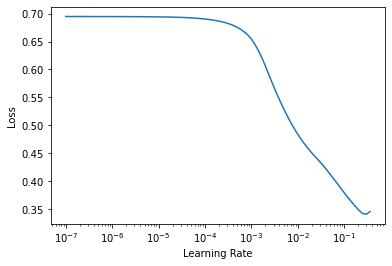

In [14]:
learn.lr_find()

# Fit Model

In [15]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.220141,0.039816,00:03
1,0.086028,0.018317,00:03
2,0.045827,0.017553,00:03
3,0.029886,0.017202,00:03
4,0.022817,0.017161,00:03


In [16]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

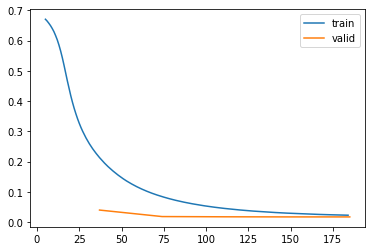

In [17]:
learn.recorder.plot_loss()

# Get Predictions for Submission
We follow the guide to setting up a test set here: https://forums.fast.ai/t/a-brief-guide-to-test-sets-in-v2-you-can-do-labelled-now-too/57054

In [18]:
test_dl = dls.test_dl(test_features)

In [19]:
test_dl.show(5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680

In [20]:
preds,_ = learn.get_preds(dl=test_dl)

In [21]:
preds.shape, preds.dtype

(torch.Size([3982, 206]), torch.float32)

In [22]:
preds_df = pd.DataFrame(preds).astype("float")

In [23]:
preds_df.head

<bound method NDFrame.head of            0         1         2         3         4         5         6    \
0     0.000867  0.001571  0.001229  0.013426  0.018678  0.005674  0.002713   
1     0.000700  0.001123  0.002369  0.017375  0.007716  0.005551  0.004589   
2     0.000001  0.000001  0.000005  0.001303  0.001585  0.000112  0.000164   
3     0.000631  0.001065  0.002436  0.019107  0.010065  0.005444  0.004420   
4     0.000501  0.000480  0.000749  0.008808  0.013185  0.003132  0.002881   
...        ...       ...       ...       ...       ...       ...       ...   
3977  0.000084  0.000518  0.000363  0.008911  0.005849  0.001847  0.000368   
3978  0.001154  0.001003  0.000862  0.005478  0.016138  0.003817  0.003539   
3979  0.000468  0.000495  0.000654  0.006070  0.012928  0.004607  0.002998   
3980  0.000355  0.000868  0.000610  0.016132  0.011970  0.002984  0.003936   
3981  0.000791  0.001042  0.001322  0.013288  0.020869  0.004944  0.003592   

           7             8       

In [24]:
submission = sub
submission[dep_var] = preds_df
submission.loc[test_features['cp_type']=='ctl_vehicle', dep_var] = 0

In [25]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000867,0.001571,0.001229,0.013426,0.018678,0.005674,0.002713,0.006921,0.000488,...,0.000322,0.000894,0.003200,0.002159,0.002408,0.000456,0.004435,0.001075,0.001282,0.001681
1,id_001897cda,0.000700,0.001123,0.002369,0.017375,0.007716,0.005551,0.004589,0.009108,0.000736,...,0.001158,0.002475,0.004363,0.010968,0.015235,0.000608,0.030027,0.001683,0.004624,0.002979
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000631,0.001065,0.002436,0.019107,0.010065,0.005444,0.004420,0.004912,0.000688,...,0.000977,0.002014,0.004955,0.021219,0.009742,0.000700,0.018879,0.002455,0.004037,0.002742
4,id_0027f1083,0.000501,0.000480,0.000749,0.008808,0.013185,0.003132,0.002881,0.003909,0.000217,...,0.000289,0.000312,0.001839,0.001373,0.000922,0.000199,0.001550,0.000926,0.001413,0.001748


In [26]:
submission.to_csv('submission.csv', index=False)